In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import pandas as pd
import pickle
import cmcrameri.cm as cmc

In [2]:
def get_scardec_stf(scardec_name, wanted_type = 'fctopt'):
    time = []
    momentrate = []

    event = os.listdir(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}')
    starts = [n for n, l in enumerate(event) if l.startswith(wanted_type)]
    with open(f'/home/earthquakes1/homes/Rebecca/phd/stf/data/scardec/{scardec_name}/{event[starts[0]]}') as f:
        lines = f.read().splitlines()

    lines = lines[2:]
    for line in lines:
        split = line.split(' ')
        split = [s for s in split if s not in ['', ' ', '\n']]
        time.append(float(split[0]))
        momentrate.append(float(split[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [3]:
def get_ye_stf(ye_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/Ye_et_al_2016/'
    momentrate = []
    time = []

    with open(data_path + str(ye_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))
    momentrate = np.array(momentrate)
    time = np.array(time)
    return momentrate, time

In [4]:
def get_usgs_stf(usgs_name):
    data_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/USGS/'
    momentrate = []
    time = []

    with open(data_path + str(usgs_name), 'r') as f:
        data = f.readlines()
        for line in data:
            line = line.strip()
            line = line.rstrip()
            if line[0] not in ['0','1','2','3','4','5','6','7','8','9']:
                continue
            line = line.split()
            time.append(float(line[0]))
            momentrate.append(float(line[1]))

    momentrate = np.array(momentrate)
    time = np.array(time)

    momentrate = momentrate / 10**7 # convert to Nm from dyne cm
    return momentrate, time

In [5]:
def get_sigloch_stf(sigloch_name):
    data_path = '/home/siglochnas1/shared/AmplitudeProjects/pdata_processed/psdata_events/'
    momentrate = []
    time = []

    file_path = data_path + str(sigloch_name) + '/outfiles/ampinv.stf.xy'

    with open(file_path, 'r') as file:
        content = file.read()
        content = content.split('\n')
        greater_than_count = content.count('>')
        if greater_than_count > 0:
            time = [list(np.arange(0, 25.6, 0.1))]
            momentrate = [[]]
            for i in range(greater_than_count-1):
                time.append(list(np.arange(0, 25.6, 0.1)))
                momentrate.append([])


        stf_count = 0
        for c in content:
            if c not in ['<', '>', '']:
                split = c.split()
                #time[stf_count].append(float(split[0]))
                momentrate[stf_count].append(10**float(split[1]))
            else:
                stf_count += 1

    # time = np.arange(0, 25.6, 0.1)
    # time = np.array(time)
    return momentrate, time

In [6]:
def get_isc_stf(isc_name):
    isc_save_path = '/home/earthquakes1/homes/Rebecca/phd/stf/data/isc/'
    with open(f'{isc_save_path}{isc_name}/{isc_name}.txt', 'rb') as f:
        stf_list = pickle.load(f)
    with open(f'{isc_save_path}{isc_name}/{isc_name}_norm_info.txt', 'rb') as f:
        norm_dict = pickle.load(f)

    time = np.arange(0, 25.6, 0.1)
    momentrate = np.array(stf_list)*norm_dict['mo_norm']*10**8,
    #print(momentrate)
    return momentrate[0], time

In [7]:
combined = pd.read_csv('/home/earthquakes1/homes/Rebecca/phd/stf/data/combined_scardec_ye_usgs_sigloch_isc_mag.csv')

In [8]:
combined.columns = ['event', 'scardec', 'ye', 'isc', 'sigloch', 'usgs', 'mag']

In [9]:
def find_end_stf(momentrate, time, dataset = ''):
    not_zero = np.where(momentrate > 0)[0]
    #print(max(momentrate))
    start = min(not_zero)
    end = max(not_zero)

    detected_end = end
    detected_end_time = time[end]

    time = time[:end]
    momentrate = momentrate[:end]

    less_than_10 = np.where(momentrate <= 10*max(momentrate)/100)[0]

    if dataset == 'sigloch':
        start = np.where(momentrate > 0.05 * max(momentrate))[0][0]
    else:
        start = min(not_zero)
    #print(less_than_10)
    total_moment = scipy.integrate.simpson(momentrate[start:end],
                                        dx = time[1]-time[0])
    #print(less_than_10)
    for i in less_than_10:
        if i <= start:
            continue
        if i == 0:
            continue
        moment = scipy.integrate.simpson(momentrate[start:i],
                                        dx = time[1]-time[0])
        #print(i, moment/total_moment)
        if moment >= 0.5 * total_moment:
            #print('inif')
            #print(f'first time where < 10% of total momentrate and 50% of moment released: {time[i]} s')
            detected_end_time = time[i]
            detected_end = i
            #print(f'proportion of moment released: {(moment/total_moment)*100:.2f}%')
            break
    return detected_end_time, detected_end, time[start], start
    #return time[end], end

In [10]:
to_ignore = ['20051203_1610_1', '20071226_2204_2', '20030122_0206_1', '20090929_1748_0', '20120421_0125_1', '20110311_2011_2']

columns_to_save = ['event', 'dataset', 'mag', 'average_momentrate', 'max_momentrate']
df_interp = pd.DataFrame(columns = columns_to_save)
max_len = 0
for i, row in combined.iterrows():
	# if i < 360:
	# 	continue

	#fig, axs = plt.subplots(2, 1, figsize=(10, 10))


	for dataset, get_stf in zip(['scardec_opt', 'scardec_moy', 'ye', 'usgs', 'sigloch', 'isc'], [get_scardec_stf, get_scardec_stf, get_ye_stf, get_usgs_stf, get_sigloch_stf, get_isc_stf]):

		if dataset == 'scardec_moy' or dataset == 'scardec_opt':
			name = row[dataset[:-4]]
		else:
			name = row[dataset]

		if name == '0' or name == 0:
			continue

		if dataset == 'scardec_moy':
			momentrate, time = get_stf(name, 'fctmoy')
		elif dataset == 'scardec_opt':
			momentrate, time = get_stf(name, 'fctopt')
		else:
			momentrate, time = get_stf(name)

		if dataset != 'sigloch':
			momentrate_list = [momentrate]
			time_list = [time]
		else:
			momentrate_list = momentrate
			time_list = time

		count = 0
		for momentrate, time in zip(momentrate_list, time_list):
			if time[0] == time[1]:
				time = time[1:]

			if dataset != 'sigloch':
				save_key = row.event
				dataset_name = dataset
			else:
				dataset_name = dataset + '_' + str(count)
				save_key = row.event + '_' + str(count)

			if save_key in to_ignore:
				continue
			#print(time[0:10])
			
			momentrate = np.array(momentrate)

			time = np.array(time)
			detected_end_time, detected_end, detected_start_time, detected_start = find_end_stf(momentrate, time, dataset)
			time = time[detected_start:detected_end] # shift to start STF at zero
			time = time - time[0]
			momentrate = momentrate[detected_start:detected_end]
			max_len = max(max_len, len(momentrate))

			max_momentrate = max(momentrate)
			average_momentrate = np.mean(momentrate)

			#axs[1].plot(np.linspace(0, 1, 100), interp_momentrate)

			df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, average_momentrate, max_momentrate]], columns = columns_to_save)], ignore_index = True)
			count += 1
	#plt.show()
	#plt.close()
	# if i > 361:
	# 	break
	# 	break


/tmp/ipykernel_546910/1242770134.py:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_interp = pd.concat([df_interp, pd.DataFrame([[row.event, dataset_name, row.mag, average_momentrate, max_momentrate]], columns = columns_to_save)], ignore_index = True)


In [11]:
def triangle(x):
    x = np.array(x)
    y = np.zeros(len(x))
    m = 1/(abs(x[0]-x[int(len(x)/2)]))
    #print(m)
    y[:int(len(x)/2)] = m*x[:int(len(x)/2)]
    y[int(len(x)/2):] = -m*x[int(len(x)/2):]
    y[:int(len(x)/2)] = y[:int(len(x)/2)] - min(y[:int(len(x)/2)])
    y[int(len(x)/2):] = y[int(len(x)/2):] - min(y[int(len(x)/2):])

    return y

In [12]:
df_interp['average_to_max_momentrate'] = df_interp['average_momentrate'] / df_interp['max_momentrate']

In [13]:
df_interp

,event,dataset,mag,average_momentrate,max_momentrate,average_to_max_momentrate
0,20170818_0259,scardec_opt,6.591,4.697965e+17,1.650963e+18,0.284559
1,20170818_0259,scardec_moy,6.591,4.670394e+17,1.558386e+18,0.299694
2,20110126_1542,scardec_opt,6.114,1.816611e+17,3.711771e+17,0.489419
3,20110126_1542,scardec_moy,6.114,1.564568e+17,3.391335e+17,0.461343
4,20110126_1542,sigloch_0,6.114,2.864434e+17,8.160350e+17,0.351019
...,...,...,...,...,...,...
11757,20230206_1024,usgs,NaN,1.296655e+12,3.949900e+12,0.328275
11758,20231202_1437,usgs,NaN,9.892551e+11,1.701800e+12,0.581299
11759,19971108_1002,usgs,NaN,5.119208e+18,1.536476e+19,0.333179
11760,20181220_1701,usgs,NaN,3.269165e+18,7.676488e+18,0.425867


In [14]:
unique_dataset_for_colors = ['scardec', 'usgs', 'sigloch', 'ye', 'isc']

colors = [cmc.batlow(i) for i in np.linspace(0, 1, len(unique_dataset_for_colors))]

dataset_for_colors = [d.split('_')[0] for d in df_interp.dataset]


In [15]:
triange_mr = triangle(np.linspace(0, 1, 1000))

In [16]:
triangle_average_to_max = np.mean(triange_mr)/max(triange_mr)

(5.0, 10.0)

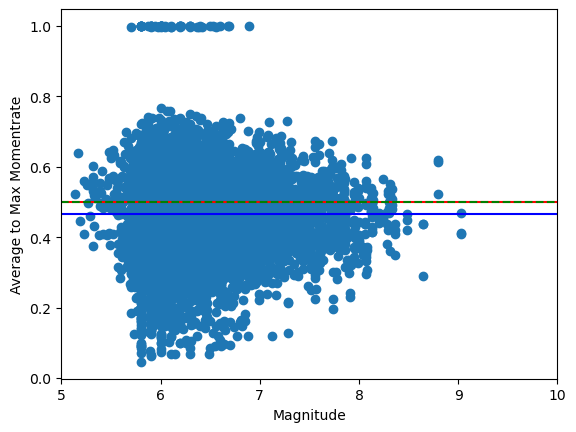

In [17]:
plt.scatter(df_interp['mag'], df_interp['average_to_max_momentrate'])
plt.hlines(0.5, 5, 10, colors='r')
plt.hlines(triangle_average_to_max, 5, 10, colors='g', linestyles='dashed')

plt.hlines(np.mean(df_interp['average_to_max_momentrate']), 5, 10, colors='b')

plt.xlabel('Magnitude')
plt.ylabel('Average to Max Momentrate')

plt.xlim(5, 10)

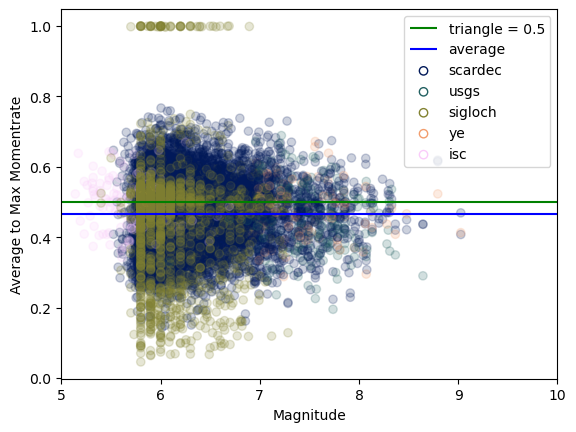

In [18]:
plt.scatter(df_interp['mag'], df_interp['average_to_max_momentrate'], 
			color = [colors[unique_dataset_for_colors.index(d)] for d in dataset_for_colors], 
			alpha=0.2)

plt.hlines(triangle_average_to_max, 5, 10, colors='g', label = 'triangle = 0.5')

plt.hlines(np.mean(df_interp['average_to_max_momentrate']), 5, 10, colors='b', label = 'average')

for d in unique_dataset_for_colors:
	plt.scatter([], [], label=d, facecolors ='none', edgecolors=colors[unique_dataset_for_colors.index(d)])

plt.xlabel('Magnitude')
plt.ylabel('Average to Max Momentrate')

plt.xlim(5, 10)

plt.legend()

#plt.savefig('/home/earthquakes1/homes/Rebecca/phd/stf/figures/average_to_max_momentrate_dataset.png')